In [1]:
# !echo numpy==1.26.4 > requirements.txt && echo matplotlib==3.9.2 >> requirements.txt && echo ipywidgets==8.1.5 >> requirements.txt
# pip install -r requirements.txt

In [2]:
# python version 3.12.7

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import ipywidgets as widgets
from IPython.display import display

In [4]:
def black_to_hsv_cmap():
    # creates a black canvas top by HSV colors
    hsv_colors = plt.cm.hsv(np.linspace(0, 1, 255))
    colors = np.vstack(([0, 0, 0, 1], hsv_colors))
    return ListedColormap(colors)

cmap = black_to_hsv_cmap()

def average_hues(values):
    # converts hue to angles then the returned agnle is changed to a radial color
    if len(values) == 0:
        return 0.0
    angles = [2 * np.pi * v for v in values]
    sum_sin = sum(np.sin(a) for a in angles)
    sum_cos = sum(np.cos(a) for a in angles)
    avg_angle = math.atan2(sum_sin, sum_cos)
    if avg_angle < 0:
        avg_angle += 2 * np.pi
    return avg_angle / (2 * np.pi)

# CA logic
class KaleidoCA:
    # define mirrored grid using .quarter to imitate kaleidoscope, and ready set of colors
    def __init__(self, size=64):
        self.size = size
        self.quarter = np.zeros((size, size), dtype=np.float32)
        center = size // 2
    
        # multiple colorful points
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if not (dx == 0 and dy == 0):
                    hue = np.random.rand()
                    self.quarter[center + dx, center + dy] = hue
    
        self.quarter[center, center] = np.random.rand()

    def step(self):
        # updates every step of the cell/neightbor
        q = self.quarter
        new_grid = np.zeros_like(q)

        '''
    Detailed explanation on README.md
    
    1. if a cell is alive and has 1 to 3 neighbors, it survives

    2.if a cell is dead but has 1 to 3 neighbors with hue, it gets the average hue of the neighbors and becomes alive

    3. if a cell has fewer than 1 or more than 3 neighbors with hue, it dies
        '''
        for x in range(self.size):
            for y in range(self.size):
                neighborhood = []
                for i in (-1, 0, 1):
                    for j in (-1, 0, 1):
                        if i == 0 and j == 0:
                            continue
                        nx, ny = x + i, y + j
                        if 0 <= nx < self.size and 0 <= ny < self.size:
                            v = q[nx, ny]
                            if v > 0:
                                neighborhood.append(v)
                n = len(neighborhood)
                c = q[x, y]

                if c > 0:
                    new_grid[x, y] = c if n in (1, 2, 3) else 0
                else:
                    if n in (1, 2, 3):
                        avg_hue = average_hues(neighborhood)
                        new_grid[x, y] = max(avg_hue, 1e-3)

        self.quarter = new_grid

    def get_full_grid(self):
        # this is the construction of the 4 grids
        q = self.quarter
        top_left = q
        top_right = np.fliplr(q)
        bottom_left = np.flipud(q)
        bottom_right = np.flipud(np.fliplr(q))
        top = np.hstack((top_left, top_right))
        bottom = np.hstack((bottom_left, bottom_right))
        return np.vstack((top, bottom))

# Tkinter GUI
class Kaleido:
    # initiates the Kaleidoscope CA to Tkinter, and GUI prep
    def __init__(self, root):
        self.root = root
        self.root.title("Kaleidoscope CA")
        self.root.geometry("1200x700")

        self.ca = KaleidoCA(size=64)
        self.initial_state = self.ca.quarter.copy()
        self.playing = False
        self.speed = 2

        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        controls = tk.Frame(root)
        controls.pack(fill=tk.X, padx=10, pady=5)

        tk.Button(controls, text="Step", command=self.step).pack(side=tk.LEFT, padx=5)
        self.play_btn = tk.Button(controls, text="Play", command=self.toggle_play)
        self.play_btn.pack(side=tk.LEFT, padx=5)
        tk.Button(controls, text="Reset", command=self.reset).pack(side=tk.LEFT, padx=5)
        tk.Button(controls, text="Re-Randomize", command=self.reseed).pack(side=tk.LEFT, padx=5)
        tk.Button(controls, text="Save Image", command=self.save_image).pack(side=tk.LEFT, padx=5)

        self.speed_slider = tk.Scale(controls, from_=1, to=10, orient=tk.HORIZONTAL,
                                     label="Speed (steps/frame)", command=self.change_speed)
        self.speed_slider.set(self.speed)
        self.speed_slider.pack(side=tk.RIGHT, padx=10)

        self.plot()

    def plot(self):
        self.ax.clear()
        grid = self.ca.get_full_grid()
        self.ax.imshow(grid, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        self.ax.axis('off')
        self.canvas.draw()

    def step(self):
        # frame by frame movement
        for i in range(self.speed):
            self.ca.step()
        self.plot()

    def toggle_play(self):
        self.playing = not self.playing
        self.play_btn.config(text="Stop" if self.playing else "Play")
        if self.playing:
            self.auto_step()

    def auto_step(self):
        # speed at which the whole CA moves
        if self.playing:
            self.step()
            self.root.after(200, self.auto_step)

    def reset(self):
        # resets the formation but retains the color combination
        self.ca.quarter = self.initial_state.copy()
        self.plot()

    def reseed(self):
        # reset CA with new colors
        self.ca = KaleidoCA(size=64)
        self.plot()

    def save_image(self):
        filename = "kaleidoscope_snapshot.png"
        self.fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"saved current kaleidoscope image as '{filename}'")

    def change_speed(self, val):
        # increase formation speed at the cost of frames
        self.speed = int(val)

# If you "Run All Cells" in Jupyter Notebook, the Tkinter window might get covered by other tabs or windows

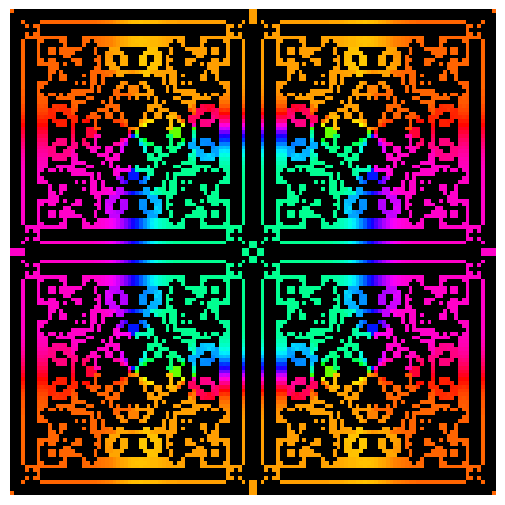

In [5]:
# creates the Tkinter window, initialize the CA, and starts the loop
root = tk.Tk()
app = Kaleido(root)
root.mainloop()

--end--